# <center> EE4708: Data Analytics Laboratory </center>


## <center> Assignment 1: Linear Regression </center>

## <center> Submitted by: Aman Kumar, EE21B013 </center>
                          

### Importing the necessary packages

In [333]:
import numpy as np                                 # Numpy for mathematical manipulations
import pandas as pd                                # Pandas for data handling and manipulation
from sklearn.linear_model import LinearRegression  # Scikit learn for performing linear regression
from sklearn.metrics import mean_squared_error     # Scikit learn for mean square error calculation
from sklearn.metrics import r2_score               # Scikit learn for R2 score calculation
import re                                          # Regular expressions for string searching
import matplotlib.pyplot as plt                    # Matplotlib for plotting
import seaborn as sns                              # Seaborn for plotting

In [334]:
plt.rcParams.update({'font.size': 13})

###  Reading in the data

Data is stored in a .xlsx file. For ease of processing, the file will be read in as a "Dataframe" using the Pandas library. This enables us to make use of the multitude of functions provided by the Pandas library.

It is assumed that the dataset is located in the same directory as this ipynb file.

In [335]:
#The first column of the given excel file can be used as the index column

df = pd.read_excel("merged_data.xlsx", index_col = 0)

### Data preprocessing and cleaning

Basic information regarding data:

In [336]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3134 entries, 0 to 3133
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   State              3134 non-null   object 
 1   AreaName           3134 non-null   object 
 2   All_Poverty        3134 non-null   int64  
 3   M_Poverty          3134 non-null   int64  
 4   F_Poverty          3134 non-null   int64  
 5   FIPS               3134 non-null   int64  
 6   Med_Income         3133 non-null   float64
 7   Med_Income_White   3132 non-null   float64
 8   Med_Income_Black   1924 non-null   float64
 9   Med_Income_Nat_Am  1474 non-null   float64
 10  Med_Income_Asian   1377 non-null   float64
 11  Hispanic           2453 non-null   float64
 12  M_With             3134 non-null   int64  
 13  M_Without          3134 non-null   int64  
 14  F_With             3134 non-null   int64  
 15  F_Without          3134 non-null   int64  
 16  All_With           3134 non-n

The task at hand is to examine the effect of socioeconomic status on cancer incidence and mortality at a <b> national level </b>. Hence, the particular state/county from which a particular datapoint is obtained is not of relevance to us.

We can therefore safely discard columns *`State`*, "*`AreaName`*", "*`FIPS`*", "*`fips_x`*" and "*`fips_y`*".

In [337]:
df = df.drop(columns = ["State", "AreaName", "FIPS", "fips_x", "fips_y"])

Next, we notice that the columns for *`Incidence_Rate`*, *`Avg_Annual_Incidence`*, *`Mortality_Rate`*, and *`Avg_Annual_Deaths`* are all categorized as having an "object" datatype. This suggests that not all values in these columns are numerical, which could pose challenges during mathematical analyses. Therefore, it is crucial to review these columns and convert all values to either numer


Let's check the unique values which appear on the column "**`Incidence_Rate`**":

In [338]:
df['Incidence_Rate'].value_counts()

Incidence_Rate
*         211
_         192
65.2       19
__         17
66.3       12
         ... 
69.7 #      1
71.4 #      1
60.7 #      1
45.3 #      1
23.7        1
Name: count, Length: 813, dtype: int64

In [339]:
# Check for differnt values present in Incidence_Rate column
non_numeric_values = df['Incidence_Rate'][~df['Incidence_Rate'].apply(lambda x: str(x).replace('.', '', 1).isdigit())].unique()
print("Non-numeric values in the column:")
print(non_numeric_values)


Non-numeric values in the column:
['*' '_' '66.2 #' '48.6 #' '53.7 #' '77.1 #' '59.1 #' '104.9 #' '74.9 #'
 '45.3 #' '60.7 #' '71.4 #' '69.7 #' '61.6 #' '71.1 #' '56.1 #' '61.7 #'
 '73.6 #' '75.6 #' '36.6 #' '73 #' '63.2 #' '50.7 #' '51.8 #' '63 #'
 '80.3 #' '79 #' '63.1 #' '66.4 #' '66 #' '62.4 #' '49.6 #' '56.8 #'
 '58.8 #' '63.5 #' '65.6 #' '60.4 #' '69.2 #' '82 #' '61.3 #' '73.4 #'
 '59.3 #' '77.4 #' '71.9 #' '35.7 #' '60 #' '54.6 #' '84 #' '61.9 #'
 '67.3 #' '64.9 #' '54.9 #' '69.4 #' '50.1 #' '58 #' '73.3 #' '63.6 #'
 '75.3 #' '78.6 #' '77.6 #' '63.8 #' '51.2 #' '73.2 #' '97 #' '87.3 #'
 '68.2 #' '39.3 #' '57.9 #' '81 #' '69.1 #' '69.5 #' '65.7 #' '50.2 #'
 '70.8 #' '77.9 #' '73.5 #' '54.4 #' '90.7 #' '__']


There are three categories of non-numerical values identified:

- `*` : This symbol indicates a very low incidence rate.
- Strings ending with `#` : These are likely numerical values with the `#` symbol introduced as noise. These data points can be used after removing the `#`.
- `_ ` and `__ ` : These likely signify that the data is unavailable.


We will first deal with the case where data is unavailable:

In [340]:
df[(df['Incidence_Rate'] == '__') | (df['Incidence_Rate'] == '_')]

,All_Poverty,M_Poverty,F_Poverty,Med_Income,Med_Income_White,Med_Income_Black,Med_Income_Nat_Am,Med_Income_Asian,Hispanic,M_With,M_Without,F_With,F_Without,All_With,All_Without,Incidence_Rate,Avg_Ann_Incidence,recent_trend,Mortality_Rate,Avg_Ann_Deaths
882,2257,957,1300,38698.0,39505.0,38482.0,20833.0,NaN,39500.0,5602,779,5754,741,11356,1520,_,_,_,52.2,10
883,1362,668,694,40696.0,40370.0,NaN,81200.0,NaN,NaN,3391,487,3407,509,6798,996,_,_,_,50.6,6
884,2970,1310,1660,43581.0,44353.0,22375.0,NaN,NaN,NaN,6755,1145,7594,963,14349,2108,_,_,_,51.1,10
885,511,245,266,51811.0,51658.0,NaN,NaN,NaN,65938.0,2170,220,2078,261,4248,481,_,_,_,56,4
886,4261,1840,2421,44013.0,45325.0,22326.0,18958.0,NaN,22247.0,11051,2075,12159,1703,23210,3778,_,_,_,45.5,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,832,350,482,45230.0,46528.0,NaN,NaN,NaN,41071.0,1995,525,1846,413,3841,938,__,__,__,61,4
1971,293,134,159,64832.0,66161.0,NaN,18438.0,NaN,NaN,1493,376,1826,210,3319,586,__,__,__,*,*
1972,65248,30454,34794,52870.0,54480.0,30773.0,42183.0,56760.0,41422.0,176960,39625,183055,32403,360015,72028,__,__,__,41.7,182
1973,987,381,606,57122.0,58096.0,NaN,52548.0,NaN,68333.0,3873,526,3532,731,7405,1257,__,__,__,46.1,6


In [341]:
df[(df['Incidence_Rate'] == '__') | (df['Incidence_Rate'] == '_')].shape

(209, 20)

Only 209 out of 3,134 entries lack incidence data. Since this represents just 6% of the total entries, we can simply drop these rows.


In [342]:
df = df[~df['Incidence_Rate'].isin(['__', '_'])]


In [343]:
# Check for differnt values present in Incidence_Rate column
non_numeric_values = df['Incidence_Rate'][~df['Incidence_Rate'].apply(lambda x: str(x).replace('.', '', 1).isdigit())].unique()
print("Non-numeric values in the column:")
print(non_numeric_values)


Non-numeric values in the column:
['*' '66.2 #' '48.6 #' '53.7 #' '77.1 #' '59.1 #' '104.9 #' '74.9 #'
 '45.3 #' '60.7 #' '71.4 #' '69.7 #' '61.6 #' '71.1 #' '56.1 #' '61.7 #'
 '73.6 #' '75.6 #' '36.6 #' '73 #' '63.2 #' '50.7 #' '51.8 #' '63 #'
 '80.3 #' '79 #' '63.1 #' '66.4 #' '66 #' '62.4 #' '49.6 #' '56.8 #'
 '58.8 #' '63.5 #' '65.6 #' '60.4 #' '69.2 #' '82 #' '61.3 #' '73.4 #'
 '59.3 #' '77.4 #' '71.9 #' '35.7 #' '60 #' '54.6 #' '84 #' '61.9 #'
 '67.3 #' '64.9 #' '54.9 #' '69.4 #' '50.1 #' '58 #' '73.3 #' '63.6 #'
 '75.3 #' '78.6 #' '77.6 #' '63.8 #' '51.2 #' '73.2 #' '97 #' '87.3 #'
 '68.2 #' '39.3 #' '57.9 #' '81 #' '69.1 #' '69.5 #' '65.7 #' '50.2 #'
 '70.8 #' '77.9 #' '73.5 #' '54.4 #' '90.7 #']


Next, we deal with values ending with #.

In [344]:
hash_indices = np.array(df[df['Incidence_Rate'].str.contains("#$", na=False)].index)

In [345]:
df.loc[hash_indices, 'Incidence_Rate'] = df.loc[hash_indices, 'Incidence_Rate'].str[:-2]

In [346]:
# Check for differnt values present in Incidence_Rate column
non_numeric_values = df['Incidence_Rate'][~df['Incidence_Rate'].apply(lambda x: str(x).replace('.', '', 1).isdigit())].unique()
print("Non-numeric values in the column:")
print(non_numeric_values)


Non-numeric values in the column:
['*']


Finally, we deal with *.

In [347]:
star_indices = df[df['Incidence_Rate'] == '*' ].index
star_indices

Index([   0,    1,    4,    5,    6,    8,   13,   21,  181,  225,
       ...
       2784, 2785, 2786, 2788, 2797, 2842, 2913, 2956, 3124, 3128],
      dtype='int64', length=211)

Since * represents very low incidence rate, we just replace it with 0.

In [348]:
df = df.drop(star_indices)

In [349]:
# Check for differnt values present in Incidence_Rate column
non_numeric_values = df['Incidence_Rate'][~df['Incidence_Rate'].apply(lambda x: str(x).replace('.', '', 1).isdigit())].unique()
print("Non-numeric values in the column:")
print(non_numeric_values)


Non-numeric values in the column:
[]


Finally, we typecast everything into float:

In [350]:
df['Incidence_Rate'] = df['Incidence_Rate'].astype('float')

Let's take a look at the current dataframe:

In [351]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2714 entries, 2 to 3133
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   All_Poverty        2714 non-null   int64  
 1   M_Poverty          2714 non-null   int64  
 2   F_Poverty          2714 non-null   int64  
 3   Med_Income         2714 non-null   float64
 4   Med_Income_White   2714 non-null   float64
 5   Med_Income_Black   1836 non-null   float64
 6   Med_Income_Nat_Am  1324 non-null   float64
 7   Med_Income_Asian   1289 non-null   float64
 8   Hispanic           2168 non-null   float64
 9   M_With             2714 non-null   int64  
 10  M_Without          2714 non-null   int64  
 11  F_With             2714 non-null   int64  
 12  F_Without          2714 non-null   int64  
 13  All_With           2714 non-null   int64  
 14  All_Without        2714 non-null   int64  
 15  Incidence_Rate     2714 non-null   float64
 16  Avg_Ann_Incidence  2714 non-n

Next, we look at Avg_Ann_Incidence:

In [352]:
# Check for differnt values present in Incidence_Rate column
non_numeric_values = df['Avg_Ann_Incidence'][~df['Avg_Ann_Incidence'].apply(lambda x: str(x).replace('.', '', 1).isdigit())].unique()
print("Non-numeric values in the column:")
print(non_numeric_values)


Non-numeric values in the column:
[]


We observe that all values in the **`Avg_Ann_Incidence`** column are numeric. However, to be cautious, we will remove all columns where the number of non-numeric values is 3 or fewer. For practical purposes, these values will be considered as 0.


In [353]:
few_indices = df[df['Avg_Ann_Incidence'] == '3 or fewer'].index
df.loc[few_indices, 'Avg_Ann_Incidence'] = 0

In [354]:
df['Avg_Ann_Incidence'] = df['Avg_Ann_Incidence'].astype('float')

In [355]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2714 entries, 2 to 3133
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   All_Poverty        2714 non-null   int64  
 1   M_Poverty          2714 non-null   int64  
 2   F_Poverty          2714 non-null   int64  
 3   Med_Income         2714 non-null   float64
 4   Med_Income_White   2714 non-null   float64
 5   Med_Income_Black   1836 non-null   float64
 6   Med_Income_Nat_Am  1324 non-null   float64
 7   Med_Income_Asian   1289 non-null   float64
 8   Hispanic           2168 non-null   float64
 9   M_With             2714 non-null   int64  
 10  M_Without          2714 non-null   int64  
 11  F_With             2714 non-null   int64  
 12  F_Without          2714 non-null   int64  
 13  All_With           2714 non-null   int64  
 14  All_Without        2714 non-null   int64  
 15  Incidence_Rate     2714 non-null   float64
 16  Avg_Ann_Incidence  2714 non-n

Next is the column of recent_trend.

In [356]:
df['recent_trend'].unique()

array(['stable', '*', 'falling', 'rising'], dtype=object)

Clearly, this is a categorical variable. We will define it as such using Pandas.

In [357]:
df['recent_trend'] = df['recent_trend'].astype(dtype = 'category')

In [358]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2714 entries, 2 to 3133
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   All_Poverty        2714 non-null   int64   
 1   M_Poverty          2714 non-null   int64   
 2   F_Poverty          2714 non-null   int64   
 3   Med_Income         2714 non-null   float64 
 4   Med_Income_White   2714 non-null   float64 
 5   Med_Income_Black   1836 non-null   float64 
 6   Med_Income_Nat_Am  1324 non-null   float64 
 7   Med_Income_Asian   1289 non-null   float64 
 8   Hispanic           2168 non-null   float64 
 9   M_With             2714 non-null   int64   
 10  M_Without          2714 non-null   int64   
 11  F_With             2714 non-null   int64   
 12  F_Without          2714 non-null   int64   
 13  All_With           2714 non-null   int64   
 14  All_Without        2714 non-null   int64   
 15  Incidence_Rate     2714 non-null   float64 
 16  Avg_Ann_Inc

Next, we analyze the mortality rate column.


In [359]:
# Check for differnt values present in Incidence_Rate column
non_numeric_values = df['Mortality_Rate'][~df['Mortality_Rate'].apply(lambda x: str(x).replace('.', '', 1).isdigit())].unique()
print("Non-numeric values in the column:")
print(non_numeric_values)


Non-numeric values in the column:
['*']


As before, we set the values conatining * to zero.

In [360]:
mortality_star_indices = df[df['Mortality_Rate'] == '*' ].index
df = df.drop(mortality_star_indices)
df['Mortality_Rate'] = df['Mortality_Rate'].astype('float')

In [361]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2641 entries, 2 to 3133
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   All_Poverty        2641 non-null   int64   
 1   M_Poverty          2641 non-null   int64   
 2   F_Poverty          2641 non-null   int64   
 3   Med_Income         2641 non-null   float64 
 4   Med_Income_White   2641 non-null   float64 
 5   Med_Income_Black   1819 non-null   float64 
 6   Med_Income_Nat_Am  1296 non-null   float64 
 7   Med_Income_Asian   1279 non-null   float64 
 8   Hispanic           2128 non-null   float64 
 9   M_With             2641 non-null   int64   
 10  M_Without          2641 non-null   int64   
 11  F_With             2641 non-null   int64   
 12  F_Without          2641 non-null   int64   
 13  All_With           2641 non-null   int64   
 14  All_Without        2641 non-null   int64   
 15  Incidence_Rate     2641 non-null   float64 
 16  Avg_Ann_Inc

Finally, we deal with the column containing averge annual deaths.

In [362]:
# Check for differnt values present in Incidence_Rate column
non_numeric_values = df['Avg_Ann_Deaths'][~df['Avg_Ann_Deaths'].apply(lambda x: str(x).replace('.', '', 1).isdigit())].unique()
print("Non-numeric values in the column:")
print(non_numeric_values)


Non-numeric values in the column:
[]


We observe that all values in the **`Avg_Ann_Deaths`** column are numeric. However, to be cautious, we will remove all columns where the number of non-numeric values is 3 or fewer. For practical purposes, these values will be considered as 0.


In [363]:
death_star_indices = df[df['Avg_Ann_Deaths'] == '*' ].index
df.loc[death_star_indices, 'Avg_Ann_Deaths'] = 0
df['Avg_Ann_Deaths'] = df['Avg_Ann_Deaths'].astype('float')

In [364]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2641 entries, 2 to 3133
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   All_Poverty        2641 non-null   int64   
 1   M_Poverty          2641 non-null   int64   
 2   F_Poverty          2641 non-null   int64   
 3   Med_Income         2641 non-null   float64 
 4   Med_Income_White   2641 non-null   float64 
 5   Med_Income_Black   1819 non-null   float64 
 6   Med_Income_Nat_Am  1296 non-null   float64 
 7   Med_Income_Asian   1279 non-null   float64 
 8   Hispanic           2128 non-null   float64 
 9   M_With             2641 non-null   int64   
 10  M_Without          2641 non-null   int64   
 11  F_With             2641 non-null   int64   
 12  F_Without          2641 non-null   int64   
 13  All_With           2641 non-null   int64   
 14  All_Without        2641 non-null   int64   
 15  Incidence_Rate     2641 non-null   float64 
 16  Avg_Ann_Inc

In [365]:
df.reset_index(inplace = True)
df = df.drop(['index'], axis = 1)

In [366]:
# checking for columns containing Null values
for col in df.columns:
    print((col,sum(df[col].isnull())))

('All_Poverty', 0)
('M_Poverty', 0)
('F_Poverty', 0)
('Med_Income', 0)
('Med_Income_White', 0)
('Med_Income_Black', 822)
('Med_Income_Nat_Am', 1345)
('Med_Income_Asian', 1362)
('Hispanic', 513)
('M_With', 0)
('M_Without', 0)
('F_With', 0)
('F_Without', 0)
('All_With', 0)
('All_Without', 0)
('Incidence_Rate', 0)
('Avg_Ann_Incidence', 0)
('recent_trend', 0)
('Mortality_Rate', 0)
('Avg_Ann_Deaths', 0)


Drop the columns **`Med_Income_Black`**, **`Med_Income_Nat_Am`**, **`Med_Income_Asian`**, and **`Hispanic`** as they contain too many null values. Imputing these columns could significantly affect the results.


In [367]:
df.drop(['Med_Income_Black','Med_Income_Nat_Am','Med_Income_Asian','Hispanic'],inplace=True,axis = 1) #dropping columns which contans too many Null values

In [368]:
df.reset_index(inplace = True)
df = df.drop(['index'], axis = 1)

In [369]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2641 entries, 0 to 2640
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   All_Poverty        2641 non-null   int64   
 1   M_Poverty          2641 non-null   int64   
 2   F_Poverty          2641 non-null   int64   
 3   Med_Income         2641 non-null   float64 
 4   Med_Income_White   2641 non-null   float64 
 5   M_With             2641 non-null   int64   
 6   M_Without          2641 non-null   int64   
 7   F_With             2641 non-null   int64   
 8   F_Without          2641 non-null   int64   
 9   All_With           2641 non-null   int64   
 10  All_Without        2641 non-null   int64   
 11  Incidence_Rate     2641 non-null   float64 
 12  Avg_Ann_Incidence  2641 non-null   float64 
 13  recent_trend       2641 non-null   category
 14  Mortality_Rate     2641 non-null   float64 
 15  Avg_Ann_Deaths     2641 non-null   float64 
dtypes: cat

With this approach, all variables are now either numerical or categorical, which simplifies the application of various mathematical tools.


### Exploratory Data Analysis

The overarching goal of the assignment is to investigate any potential correlation between socioeconomic status and cancer incidence or death.

To begin, we will make some qualitative observations through various plots. These observations will provide insights that can later be used for quantitative analyses.


For most of the plots, we require numerical variables exclusively. Let us make a dataframe containing just the numerical variables:

In [370]:
numerical_df = df.loc[:, df.columns != 'recent_trend']

Let us first plot a correlation heatmap to get a sense of the correlations of the variables involved:

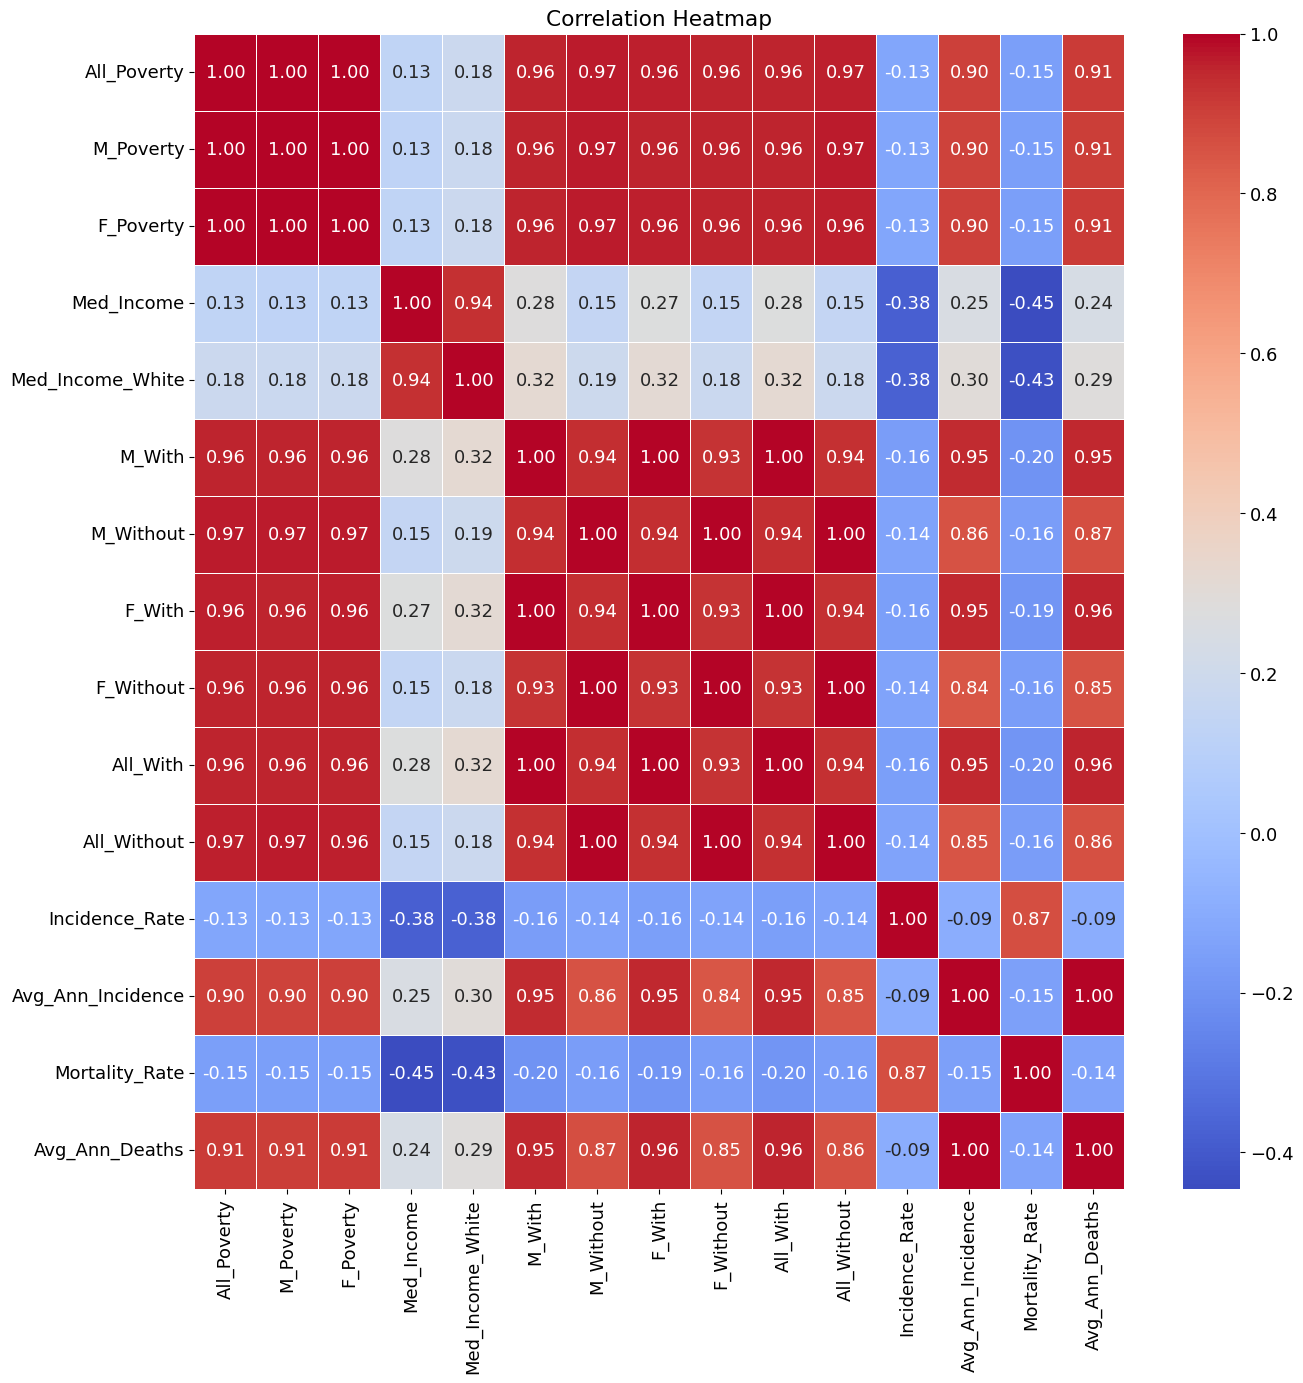

In [371]:
# Set the figure size
plt.figure(figsize=(15, 15))

# Plot the heatmap of the correlation matrix
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Our objective is to evaluate the impact of the following two factors on cancer incidence and mortality:
- Economic status
- Social status


Our initial focus is on examining how economic status may relate to cancer incidence and mortality.


From the available dataset, we make the following observations:

- The variables related to **economic status** are:
    - **Number of individuals below the poverty line**
    - **Median income of individuals**

- We anticipate a **positive correlation** between the **incidence/mortality rate** and the **poverty rate**. Conversely, we expect a **negative correlation** between **median income** and the **incidence/mortality rate**.


Before we set out to compute the relationships, it is important to understand the difference between the features **`Incidence_Rate`** and **`Avg_Ann_Incidence`**, and between **`Mortality_Rate`** and **`Avg_Ann_Deaths`**.

**`Avg_Ann`** quantities represent **the numbers for the entire population**, whereas **`Incidence_Rate`** and **`Mortality_Rate`** represent **the numbers normalized using the total population**.

Since what is of relevance to us is the **per capita rate**, **we shall be considering only `Incidence_Rate` and `Mortality_Rate`**.


From the heatmap, we see that the **correlation between `All_Poverty` and `Incidence_Rate` is -0.13**, which is almost 0! Does this mean there is no correlation between the two?

An important fact to note is that **`All_Poverty`** represents the total number of individuals below the poverty line, i.e., **it has not been normalized with respect to the total population**, whereas **`Incidence_Rate`** is already normalized. Therefore, it is necessary to **normalize `All_Poverty` with respect to the total population** as well.

We can approximate the total population as the sum of all people with health insurance and all people without health insurance. Additionally, we will calculate the male and female populations separately to be used later.


In [372]:
df.insert(loc = 0, column = 'All_Population', value = df['All_With'] + df['All_Without'])
df.insert(loc = 1, column = 'M_Population', value = df['M_With'] + df['M_Without'])
df.insert(loc = 2, column = 'F_Population', value = df['F_With'] + df['F_Without'])

Calculating the poverty rate per 100000 individuals:

In [373]:
df.insert(loc = 3, column = 'All_Poverty_Rate', value = df['All_Poverty']*100000/df['All_Population'])
df.insert(loc = 4, column = 'M_Poverty_Rate', value = df['M_Poverty']*100000/df['M_Population'])
df.insert(loc = 5, column = 'F_Poverty_Rate', value = df['F_Poverty']*100000/df['F_Population'])

Removing the absolute values since they are not relevant to our analysis:


In [374]:
df.drop(['All_Poverty', 'M_Poverty', 'F_Poverty'], axis = 1, inplace = True)

Now let us compute the correlation again:

In [375]:
df['All_Poverty_Rate'].corr(df['Incidence_Rate'])

0.3266745373834793

We see a significant positive correlation just like we expected! Let us visualize this through a plot:

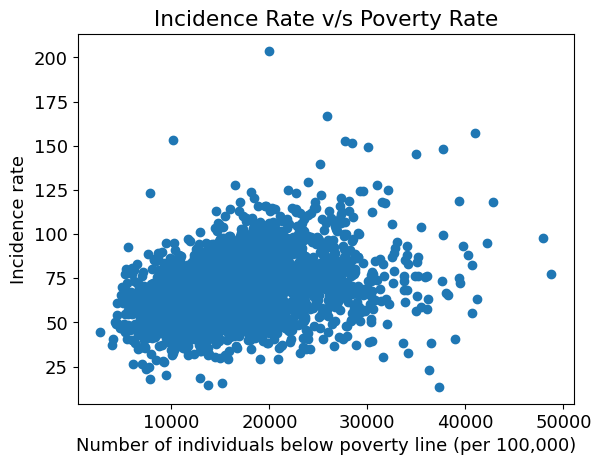

In [376]:
# Create a scatter plot
plt.scatter(df['All_Poverty_Rate'], df['Incidence_Rate'])
plt.xlabel("Number of individuals below poverty line (per 100,000)")
plt.ylabel("Incidence rate")
plt.title(" Incidence Rate v/s Poverty Rate ")
plt.savefig("incidence_poveryBelow.png")  # Save the plot as a PNG file
plt.show()

We see a general positive correlation in the plot as well.

We repeat for Mortality_Rate:

In [377]:
df['All_Poverty_Rate'].corr(df['Mortality_Rate'])

0.3833130201646359

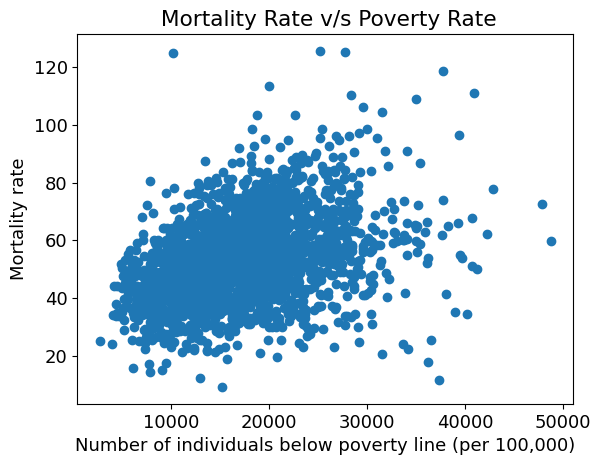

In [378]:
# Create a scatter plot
plt.scatter(df['All_Poverty_Rate'], df['Mortality_Rate'])
plt.xlabel("Number of individuals below poverty line (per 100,000)")
plt.ylabel("Mortality rate")
plt.title(" Mortality Rate v/s Poverty Rate")
plt.savefig("Mortality_Poverty.png")  # Save the plot as a PNG file
plt.show()

We see a general positive correlation here as well.

Next, we examine Median Income feature. 

In [379]:
df['Med_Income'].corr(df['Incidence_Rate'])

-0.37979277006932666

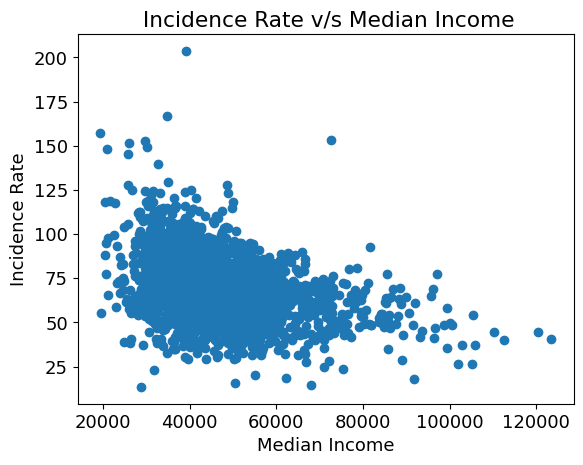

In [380]:
# Create a scatter plot
plt.scatter(df['Med_Income'], df['Incidence_Rate'])
plt.xlabel("Median Income")
plt.ylabel("Incidence Rate")
plt.title(" Incidence Rate v/s Median Income")
plt.savefig("incidence_median.png")  # Save the plot as a PNG file
plt.show()

In [381]:
df['Med_Income'].corr(df['Mortality_Rate'])

-0.4451519235283165

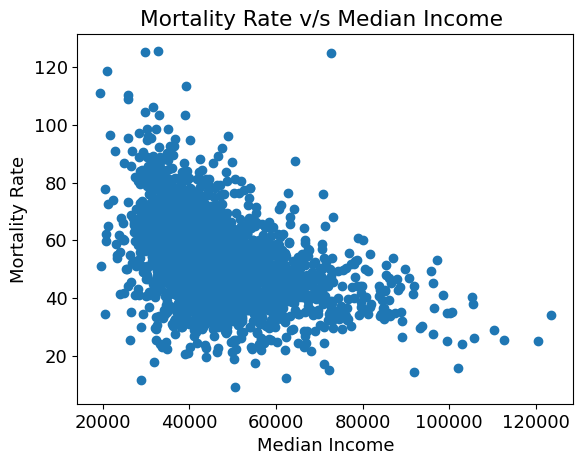

In [382]:
# Create a scatter plot
plt.scatter(df['Med_Income'], df['Mortality_Rate'])
plt.xlabel("Median Income")
plt.ylabel("Mortality Rate")
plt.title("Mortality Rate v/s Median Income ")
plt.savefig("Mortality_Median.png")  # Save the plot as a PNG file
plt.show()

**From the correlation values and plots, it can be qualitatively concluded that as poverty increases or income decreases, there is a higher chance of cancer incidence and mortality in general.**


Let us also explore the effect of having **health insurance** on our target parameters. For this, similar to the previous case, it is necessary to compute the **per capita values**.


In [383]:
#To compute the per capita values for health insurance, we insert the following columns into the DataFrame:

# Insert new columns for insurance rates into the DataFrame
df.insert(loc = 12, column = 'All_Insurance_Rate', value = df['All_With']/df['All_Population'])
df.insert(loc = 13, column = 'M_Insurance_Rate', value = df['M_With']/df['M_Population'])
df.insert(loc = 14, column = 'F_Insurance_Rate', value = df['F_With']/df['F_Population'])


In [384]:
df.columns

Index(['All_Population', 'M_Population', 'F_Population', 'All_Poverty_Rate',
       'M_Poverty_Rate', 'F_Poverty_Rate', 'Med_Income', 'Med_Income_White',
       'M_With', 'M_Without', 'F_With', 'F_Without', 'All_Insurance_Rate',
       'M_Insurance_Rate', 'F_Insurance_Rate', 'All_With', 'All_Without',
       'Incidence_Rate', 'Avg_Ann_Incidence', 'recent_trend', 'Mortality_Rate',
       'Avg_Ann_Deaths'],
      dtype='object')

In [385]:
df['All_Insurance_Rate']

0       0.844905
1       0.743959
2       0.868101
3       0.854663
4       0.787795
          ...   
2636    0.865122
2637    0.831483
2638    0.859531
2639    0.830681
2640    0.886759
Name: All_Insurance_Rate, Length: 2641, dtype: float64

In [386]:
df['All_Insurance_Rate'].corr(df['Incidence_Rate'])

-0.03842857344984531

It seems like there **isn't any correlation** at all between **cancer incidence** and having **health insurance**. This is to be expected because **health insurance** is primarily useful for the **treatment** of a disease, not so much for its **prevention**.


In [387]:
df['All_Insurance_Rate'].corr(df['Mortality_Rate'])

-0.12407424204628002

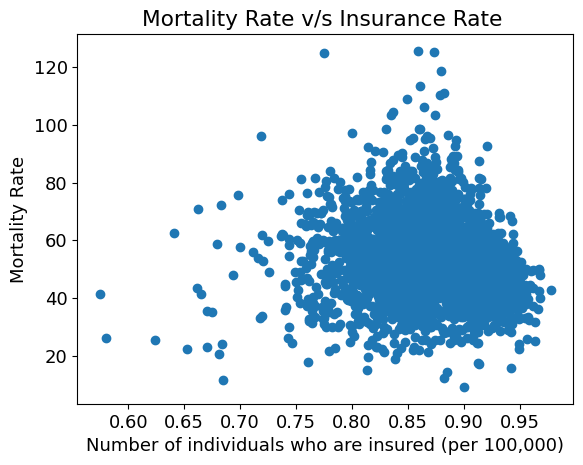

In [388]:
#To visualize the relationship between the insurance rate and the mortality rate, we generate the following scatter plot:
# Create a scatter plot
plt.scatter(df['All_Insurance_Rate'], df['Mortality_Rate'])
plt.xlabel("Number of individuals who are insured (per 100,000)")
plt.ylabel("Mortality Rate")
plt.title("Mortality Rate v/s Insurance Rate ")
plt.savefig("Mortality_Insurance.png")  # Save the plot as a PNG file
plt.show()
#

Unlike the case of cancer incidence, there seems to be a **significant negative correlation** between having **health insurance** and the **mortality rate**. Again, this is to be expected since having **health insurance** provides an incentive for individuals to seek appropriate treatment without considering financial limitations.


Next, our target is to associate **social status** with **cancer incidence** and **mortality**.


Towards this, we shall consider the following two broad social classification criterion:
- Gender
- Ethnicity

The major challenge we face is that we **do not have direct access** to **incidence/mortality rate** for each **section** separately. For instance, we do not know the separate count of **male** individuals and **female** individuals having cancer incidence. This prohibits any **direct comparison**.


As a result, it is necessary to make an **indirect comparison** based on the available parameters.


To begin, we consider gender. For gender, we have the following parameters available:
- Poverty rate for males and females separately
- Rate of individuals with life insurance for males and females separately


Since our earlier analysis has already concluded that the **poverty rate** is positively correlated with both the **incidence rate** and the **mortality rate**, if we determine that one section has a **higher poverty rate** in general, we can infer that this section likely experiences **higher incidence** and **mortality rates** as well.


Let us make box plots for the two sections:

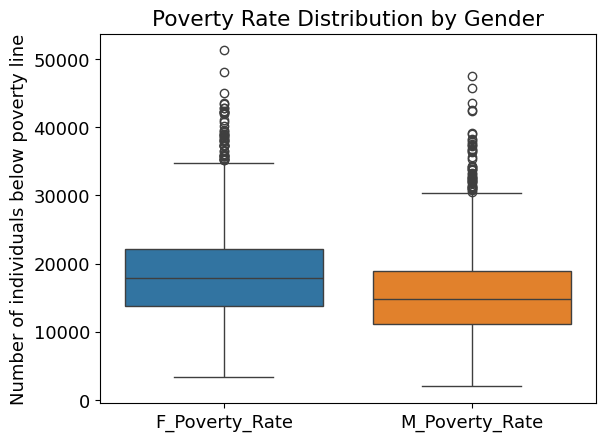

In [389]:
#To visualize the distribution of poverty rates by gender, we generate the following boxplot:

# Create a boxplot for poverty rates by gender
sns.boxplot(data=df[["F_Poverty_Rate", "M_Poverty_Rate"]])
plt.ylabel("Number of individuals below poverty line")
plt.title("Poverty Rate Distribution by Gender")
plt.savefig("box_pov.png")  # Save the plot as a PNG file
plt.show()


From the plot, it seems that the <b>poverty rate is higher for the female population</b>, atleast qualitatively. To see this quantitatively, consider:

In [390]:
df[["F_Poverty_Rate", "M_Poverty_Rate"]].describe()

,F_Poverty_Rate,M_Poverty_Rate
count,2641.000000,2641.000000
mean,18434.765541,15446.423698
std,6672.658521,6016.711769
min,3422.382671,1972.637607
25%,13751.254677,11147.762835
50%,17889.460045,14868.870296
75%,22203.040597,18858.858859
max,51264.842540,47576.177285


As observed, the **mean and median poverty rates are higher for the female population**. Therefore, it can be concluded that the female population generally experiences a **higher poverty rate** and, as a result, **higher values for cancer incidence and mortality rates**.


For health insurance:

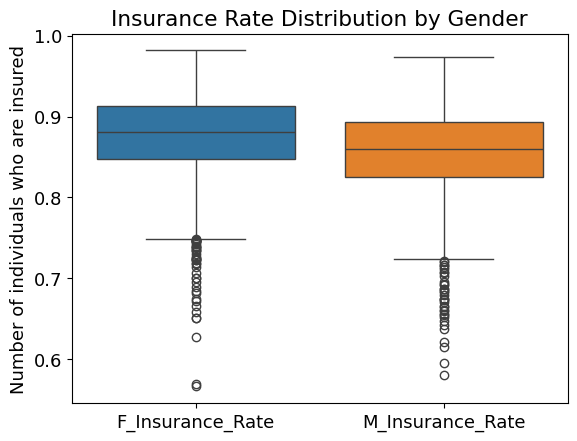

In [391]:
#To visualize the distribution of insurance rates by gender, we generate the following boxplot:

# Create a boxplot for insurance rates by gender
sns.boxplot(data=df[["F_Insurance_Rate", "M_Insurance_Rate"]])
plt.ylabel("Number of individuals who are insured")
plt.title("Insurance Rate Distribution by Gender")
plt.savefig("box_ins.png")  # Save the plot as a PNG file
plt.show()

Next, we explore the relationship between ethnicity and cancer incidence/mortality.


In this case, the parameter available to us is **median income**. As we have observed earlier, a **lower median income** corresponds to **higher cancer incidence** and **mortality**.


The Median Income data by ethinicity is not accurate it contains too many Null values so it is not good to analyze it by ethinicity.

From our previous discussion, it is reasonable to assume that the incidence rate/mortality rate might also vary accordingly.

<b> Incidence v/s Mortality

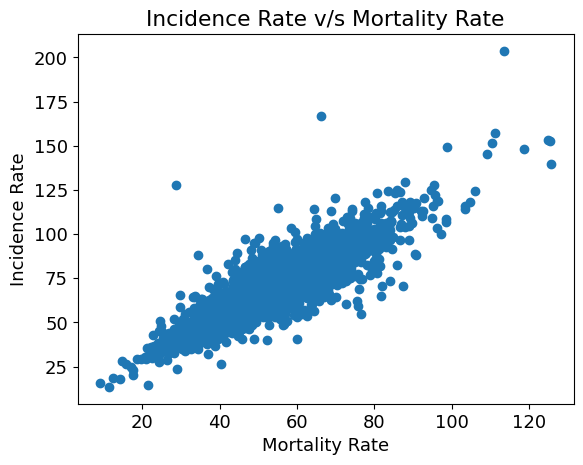

In [392]:
#To visualize the relationship between the **mortality rate** and the **incidence rate**, we generate the following scatter plot:

# Create a scatter plot for mortality rate vs. incidence rate
plt.scatter(df['Mortality_Rate'], df['Incidence_Rate'])
plt.xlabel("Mortality Rate")
plt.ylabel("Incidence Rate")
plt.title("Incidence Rate v/s Mortality Rate")
plt.savefig('incidence_Mortality.png')  # Save the plot as a PNG file
plt.show()


In [393]:
df[['Mortality_Rate', 'Incidence_Rate']].corr()

,Mortality_Rate,Incidence_Rate
Mortality_Rate,1.000000,0.866994
Incidence_Rate,0.866994,1.000000


### Applying Linear Regression

To formally validate the observations made during the Exploratory Data Analysis (EDA), we apply **linear regression**.

#### **Model 1: Using only poverty rate**

We train a linear regression model that uses only the **poverty rate** to predict the **incidence/mortality rate**. The **error** of this model will then serve as an indicator of how effective the poverty rate is as a predictor.


In [394]:
arr_poverty = np.array(df['All_Poverty_Rate'])
arr_incidence = np.array(df['Incidence_Rate'])
                         
poverty_reg = LinearRegression().fit(arr_poverty.reshape(-1, 1), arr_incidence)
poverty_predictions = poverty_reg.predict(arr_poverty.reshape(-1, 1))

In [395]:
poverty_reg.coef_

array([0.00092117])

In [396]:
arr_incidence.shape

(2641,)

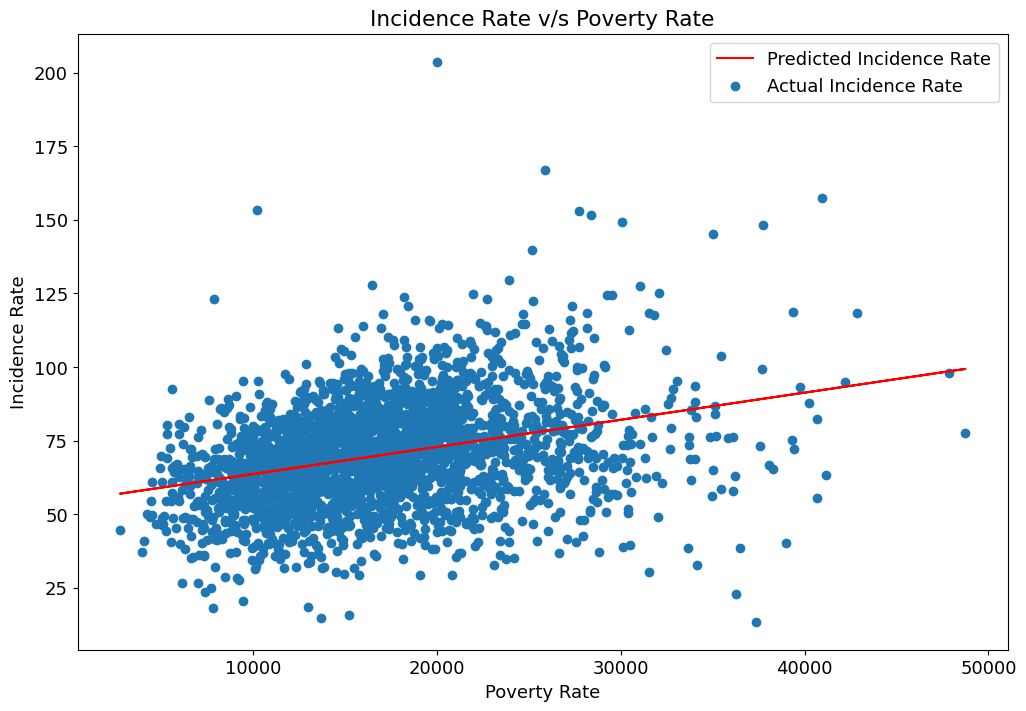

In [397]:
#To visualize the performance of **Model 1**, which uses only the **poverty rate** to predict the **incidence rate**, we generate the following plot:

# Create a plot for the predicted vs. actual incidence rate
plt.figure(figsize=(12, 8))
plt.plot(arr_poverty, poverty_predictions.reshape(-1), 'r', label="Predicted Incidence Rate")
plt.scatter(arr_poverty, arr_incidence, label="Actual Incidence Rate")
plt.xlabel('Poverty Rate')
plt.ylabel('Incidence Rate')
plt.title('Incidence Rate v/s Poverty Rate')
plt.legend()
plt.savefig("m1_Incidence_Poverty.png")  # Save the plot as a PNG file
plt.show()


In [398]:
mse = mean_squared_error(poverty_predictions, arr_incidence)
mse

279.29164117810336

In [399]:
poverty_r2 = r2_score(arr_incidence, poverty_predictions)
poverty_r2

0.10671625337471025

In [400]:
#To train a linear regression model using **poverty rate** to predict **mortality rate**, and to generate predictions, we use the following code:


# Convert relevant columns to numpy arrays
arr_poverty = np.array(df['All_Poverty_Rate'])
arr_mortality = np.array(df['Mortality_Rate'])

# Initialize and fit the linear regression model
poverty_mor_reg = LinearRegression().fit(arr_poverty.reshape(-1, 1), arr_mortality)

# Generate predictions
poverty_mor_predictions = poverty_mor_reg.predict(arr_poverty.reshape(-1, 1))


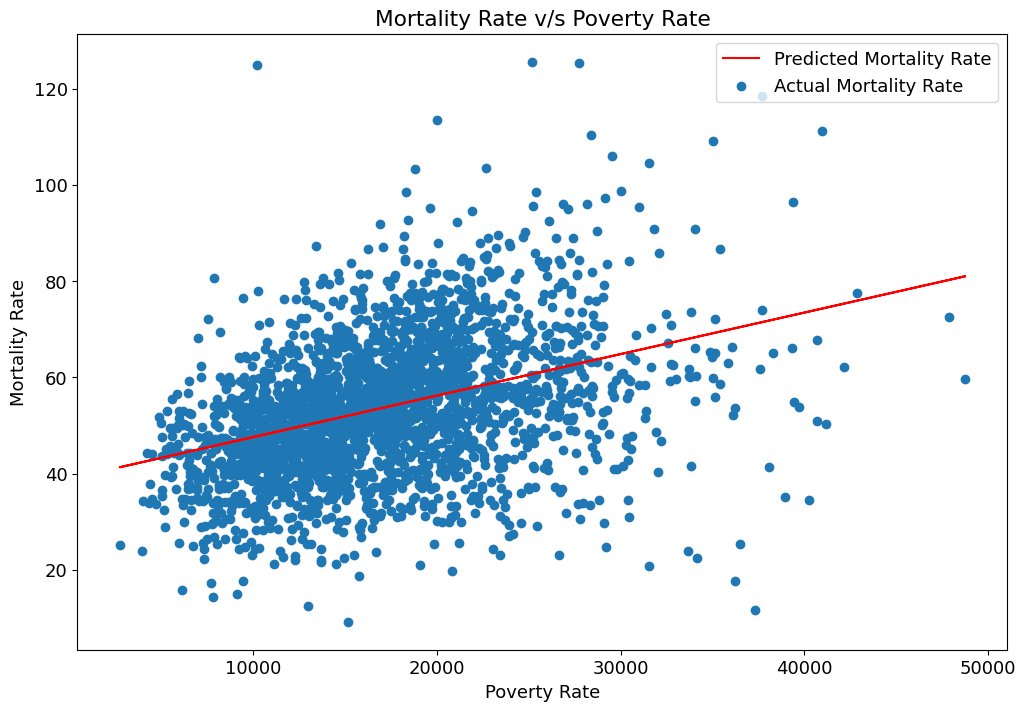

In [401]:
#To visualize the performance of **Model 1** in predicting the **mortality rate** based on the **poverty rate**, we generate the following plot:


# Create a plot for the predicted vs. actual mortality rate
plt.figure(figsize=(12, 8))
plt.plot(arr_poverty, poverty_mor_predictions.reshape(-1), 'r', label="Predicted Mortality Rate")
plt.scatter(arr_poverty, arr_mortality, label="Actual Mortality Rate")
plt.xlabel('Poverty Rate')
plt.ylabel('Mortality Rate')
plt.title('Mortality Rate v/s Poverty Rate')
plt.legend(loc='upper right')
plt.savefig("m1_mortality_poverty.png")  # Save the plot as a PNG file
plt.show()


In [402]:
mse_pov_mor = mean_squared_error(poverty_mor_predictions, arr_mortality)
print(mse_pov_mor)
poverty_mor_r2 = r2_score(arr_mortality, poverty_mor_predictions)
print(poverty_mor_r2)

169.9040079847183
0.1469288714277348


#### **Model 2: Using only median income**

In [403]:
#To train a linear regression model using **median income** to predict **incidence rate**, and to generate predictions, we use the following code:

# Convert the median income column to a numpy array
arr_income = np.array(df['Med_Income'])

# Initialize and fit the linear regression model
income_reg = LinearRegression().fit(arr_income.reshape(-1, 1), arr_incidence)

# Generate predictions
income_predictions = income_reg.predict(arr_income.reshape(-1, 1))


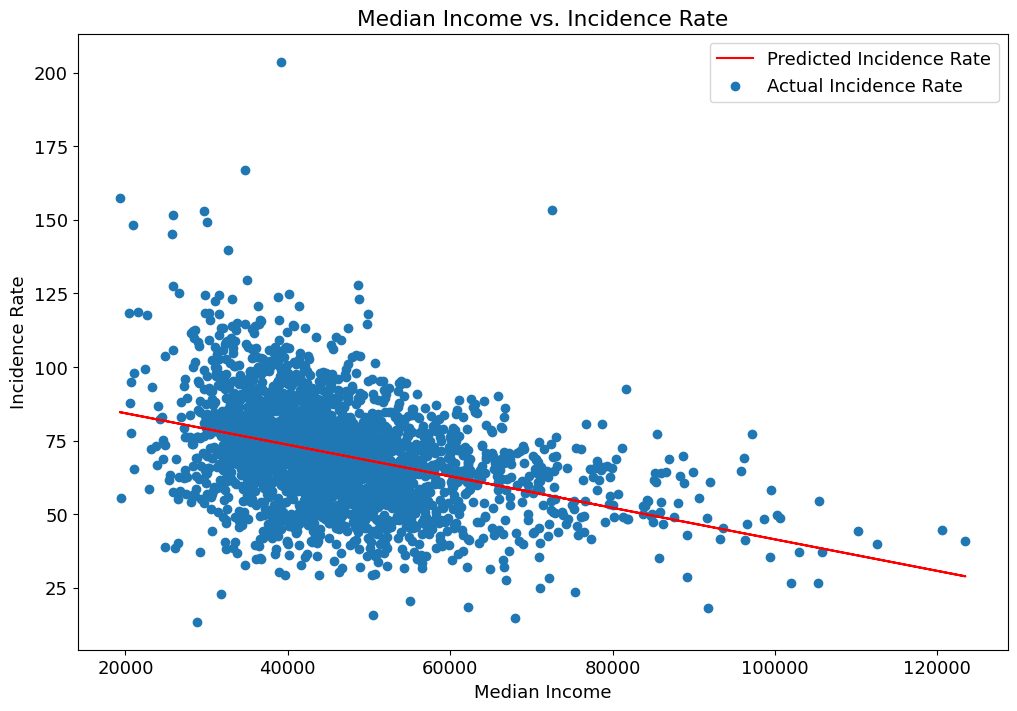

In [404]:
#To visualize the performance of **Model 2** in predicting the **incidence rate** based on **median income**, we generate the following plot:

# Create a plot for the predicted vs. actual incidence rate
plt.figure(figsize=(12, 8))
plt.plot(arr_income, income_predictions, 'r', label="Predicted Incidence Rate")
plt.scatter(arr_income, arr_incidence, label="Actual Incidence Rate")
plt.xlabel("Median Income")
plt.ylabel("Incidence Rate")
plt.title("Median Income vs. Incidence Rate")
plt.legend(loc='upper right')
plt.savefig("m2_inc.png")  # Save the plot as a PNG file
plt.show()


To evaluate the performance of **Model 2**, which predicts the **incidence rate** based on **median income**, we calculate the **Mean Squared Error (MSE)** and **R-squared (R²)** values. These metrics help us understand how well the model fits the data.


In [405]:

# Compute Mean Squared Error (MSE)
income_mse = mean_squared_error(arr_incidence, income_predictions)
print(f"Mean Squared Error (MSE): {income_mse}")

# Compute R-squared (R²) value
income_r2 = r2_score(arr_incidence, income_predictions)
print(f"R-squared (R²): {income_r2}")


Mean Squared Error (MSE): 267.5587729737654
R-squared (R²): 0.14424254819693239


To train a linear regression model using **median income** to predict **mortality rate**, and to generate predictions, we use the following code:


In [406]:

# Convert the median income column to a numpy array
arr_income = np.array(df['Med_Income'])

# Initialize and fit the linear regression model
income_mor_reg = LinearRegression().fit(arr_income.reshape(-1, 1), arr_mortality)

# Generate predictions for mortality rate
income_mor_predictions = income_mor_reg.predict(arr_income.reshape(-1, 1))


To visualize the performance of **Model 2** in predicting the **mortality rate** based on **median income**, we generate the following plot:


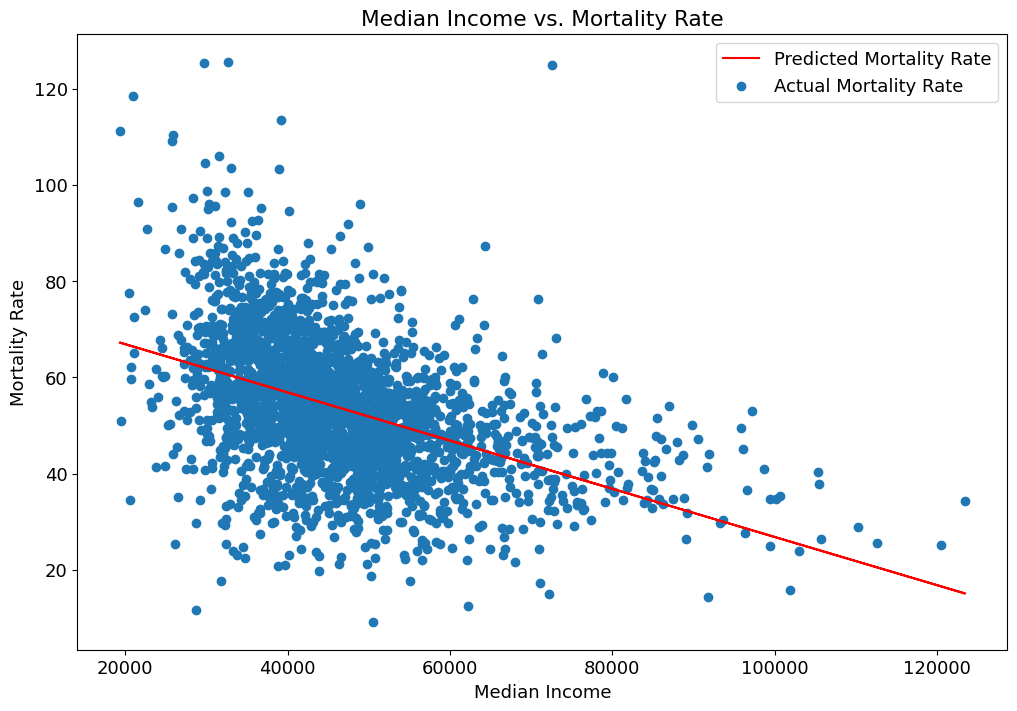

In [407]:

# Create a plot for the predicted vs. actual mortality rate
plt.figure(figsize=(12, 8))
plt.plot(arr_income, income_mor_predictions, 'r', label="Predicted Mortality Rate")
plt.scatter(arr_income, arr_mortality, label="Actual Mortality Rate")
plt.xlabel("Median Income")
plt.ylabel("Mortality Rate")
plt.title("Median Income vs. Mortality Rate")
plt.legend(loc='upper right')
plt.savefig("m2_mor.png")  # Save the plot as a PNG file
plt.show()


To evaluate the performance of the linear regression model predicting **mortality rate** based on **median income**, we calculate the **mean squared error (MSE)** and the **R-squared score (R²)** as follows:


In [408]:


# Calculate mean squared error for the mortality rate predictions
mse_inc_mor = mean_squared_error(arr_mortality, income_mor_predictions)
print(f"Mean Squared Error (MSE) for Mortality Rate Predictions: {mse_inc_mor}")

# Calculate R-squared score for the mortality rate predictions
inc_mor_r2 = r2_score(arr_mortality, income_mor_predictions)
print(f"R-squared Score (R²) for Mortality Rate Predictions: {inc_mor_r2}")


Mean Squared Error (MSE) for Mortality Rate Predictions: 159.7003875391648
R-squared Score (R²) for Mortality Rate Predictions: 0.19816023502096014


#### **Model 3: Using both poverty rate and median income** 

In [409]:

# Extract the relevant columns for joint regression
arr_joint = np.array(df[['All_Poverty_Rate', 'Med_Income']])

# Initialize and fit the linear regression model using both poverty rate and median income
joint_reg = LinearRegression().fit(arr_joint, arr_incidence.reshape(-1, 1))

# Predict incidence rate using the fitted model
joint_predictions = joint_reg.predict(arr_joint)


In [410]:
arr_joint.shape

(2641, 2)

In [411]:
arr_incidence.shape

(2641,)

In [412]:
len(joint_predictions)

2641

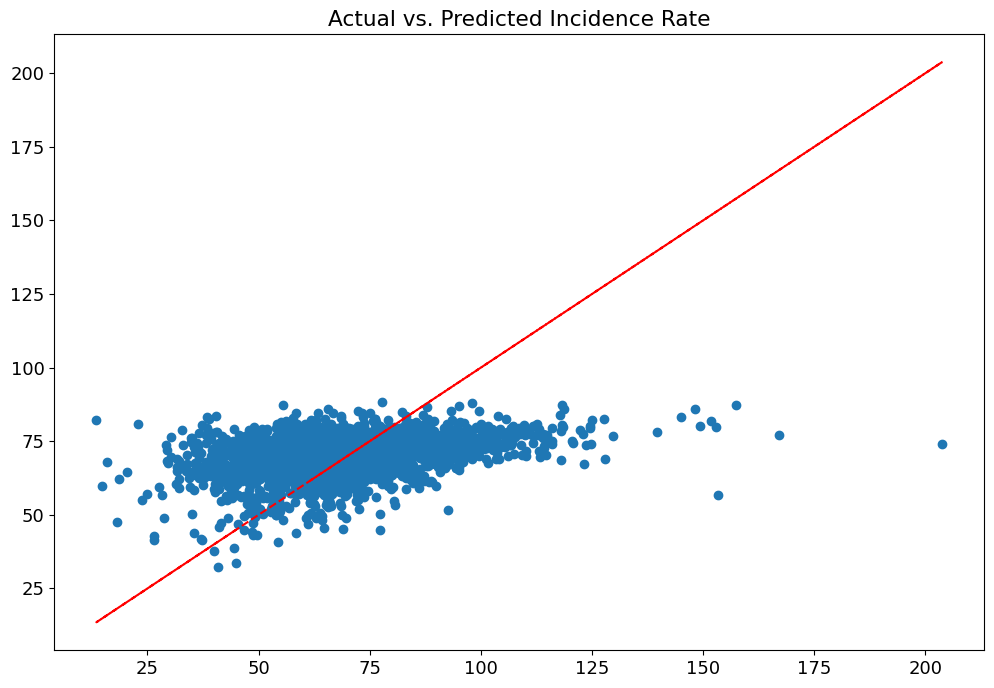

In [413]:

# Create a scatter plot of actual vs predicted incidence rates
plt.figure(figsize=(12, 8))
plt.scatter(arr_incidence, joint_predictions, label="Predicted Incidence Rate")

# Plot the line where predictions equal actual values
plt.plot(arr_incidence, arr_incidence, 'r--', label="Ideal Prediction Line")

plt.title("Actual vs. Predicted Incidence Rate")

# Save the plot
plt.savefig("Actual_predicted_incidence.png")

# Show the plot
plt.show()


In [414]:
# Compute Mean Squared Error (MSE)
joint_mse = mean_squared_error(arr_incidence, joint_predictions)
print("Mean Squared Error (MSE):", joint_mse)

# Compute R-squared score
joint_r2 = r2_score(arr_incidence, joint_predictions)
print("R-squared Score:", joint_r2)

Mean Squared Error (MSE): 266.95320069308394
R-squared Score: 0.14617940485851277


In [415]:
# Prepare the data
arr_joint = np.array(df[['All_Poverty_Rate', 'Med_Income']])
arr_mortality = np.array(df['Mortality_Rate'])

# Fit the linear regression model
joint_mor_reg = LinearRegression().fit(arr_joint, arr_mortality)

# Predict mortality rates using the model
joint_mor_predictions = joint_mor_reg.predict(arr_joint)

# Compute Mean Squared Error (MSE)
joint_mor_mse = mean_squared_error(arr_mortality, joint_mor_predictions)
print("Mean Squared Error (MSE) for Mortality Rate Prediction:", joint_mor_mse)

# Compute R-squared score
joint_mor_r2 = r2_score(arr_mortality, joint_mor_predictions)
print("R-squared Score for Mortality Rate Prediction:", joint_mor_r2)

Mean Squared Error (MSE) for Mortality Rate Prediction: 159.1562771153726
R-squared Score for Mortality Rate Prediction: 0.2008921593516333


In [416]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Prepare the data
arr_joint = np.array(df[['All_Poverty_Rate', 'Med_Income']])
arr_incidence = np.array(df['Incidence_Rate'])
arr_mortality = np.array(df['Mortality_Rate'])

# Polynomial features with degree 6
poly = PolynomialFeatures(6)
new_feat = poly.fit_transform(arr_joint)

# Polynomial Regression for Incidence Rate
poly_reg = LinearRegression().fit(new_feat, arr_incidence.reshape(-1, 1))
poly_predictions = poly_reg.predict(new_feat)

# Compute Mean Squared Error (MSE) and R-squared score for Incidence Rate
poly_mse = mean_squared_error(arr_incidence, poly_predictions)
print("Polynomial Regression MSE for Incidence Rate:", poly_mse)
poly_r2 = r2_score(arr_incidence, poly_predictions)
print("Polynomial Regression R-squared Score for Incidence Rate:", poly_r2)

# Polynomial Regression for Mortality Rate
poly_mor_reg = LinearRegression().fit(new_feat, arr_mortality.reshape(-1, 1))
poly_mor_predictions = poly_mor_reg.predict(new_feat)

# Compute Mean Squared Error (MSE) and R-squared score for Mortality Rate
poly_mor_mse = mean_squared_error(arr_mortality, poly_mor_predictions)
print("Polynomial Regression MSE for Mortality Rate:", poly_mor_mse)
poly_mor_r2 = r2_score(arr_mortality, poly_mor_predictions)
print("Polynomial Regression R-squared Score for Mortality Rate:", poly_mor_r2)


Polynomial Regression MSE for Incidence Rate: 249.58291669347525
Polynomial Regression R-squared Score for Incidence Rate: 0.20173635710263982
Polynomial Regression MSE for Mortality Rate: 146.2427549142747
Polynomial Regression R-squared Score for Mortality Rate: 0.26572967018259863
